In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.layers import Dense, Input
from keras.models import Model

from sklearn.metrics import mean_absolute_percentage_error

np.random.seed(123)
tf.random.set_seed(123)

In [2]:
!curl -O https://lazyprogrammer.me/course_files/airline_passengers.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  2036  100  2036    0     0   1313      0  0:00:01  0:00:01 --:--:--  1314


In [3]:
df = pd.read_csv('airline_passengers.csv', index_col='Month', parse_dates=True)
df['LogPassengers'] = np.log(df['Passengers'])
df.head()

,Passengers,LogPassengers
Month,,
1949-01-01,112,4.718499
1949-02-01,118,4.770685
1949-03-01,132,4.882802
1949-04-01,129,4.859812
1949-05-01,121,4.795791


In [11]:
Ntest = 12
train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]

train_idx = df.index <= train.index[-1]
test_idx = ~train_idx

In [5]:
df['DiffLogPassengers'] = df['LogPassengers'].diff()

In [6]:
series = df['DiffLogPassengers'].dropna().to_numpy()

T = 10
X = [series[t:t+T] for t in range(len(series) - T)]
Y = [series[t+T] for t in range(len(series) - T)]

X = np.array(X).reshape(-1, T)
Y = np.array(Y)
N = len(X)
X.shape, Y.shape

((133, 10), (133,))

In [7]:
Xtrain, Ytrain = X[:-Ntest], Y[:-Ntest]
Xtest, Ytest = X[-Ntest:], Y[-Ntest:]

In [8]:
# Build the model
i = Input(shape=(T,))
x = Dense(32, activation='relu')(i)
x = Dense(1)(x)
model = Model(i, x)

In [9]:
model.compile(
    loss='mse', # mse for regression
    optimizer='adam'
)
r = model.fit(
    Xtrain, Ytrain, epochs=150,
    validation_data=(Xtest, Ytest)
)


Epoch 1/150

4/4 [==============================] - 1s 97ms/step - loss: 0.0175 - val_loss: 0.0150
Epoch 2/150
4/4 [==============================] - 0s 21ms/step - loss: 0.0154 - val_loss: 0.0134
Epoch 3/150
4/4 [==============================] - 0s 21ms/step - loss: 0.0138 - val_loss: 0.0122
Epoch 4/150
4/4 [==============================] - 0s 17ms/step - loss: 0.0125 - val_loss: 0.0112
Epoch 5/150
4/4 [==============================] - 0s 16ms/step - loss: 0.0113 - val_loss: 0.0103
Epoch 6/150
4/4 [==============================] - 0s 17ms/step - loss: 0.0104 - val_loss: 0.0095
Epoch 7/150
4/4 [==============================] - 0s 16ms/step - loss: 0.0095 - val_loss: 0.0089
Epoch 8/150
4/4 [==============================] - 0s 16ms/step - loss: 0.0088 - val_loss: 0.0083
Epoch 9/150
4/4 [==============================] - 0s 17ms/step - loss: 0.0081 - val_loss: 0.0079
Epoch 10/150
4/4 [==============================] - 0s 17ms/step - loss: 0.0075 - val_loss: 0.0075
Epoch 11/150
4/4 

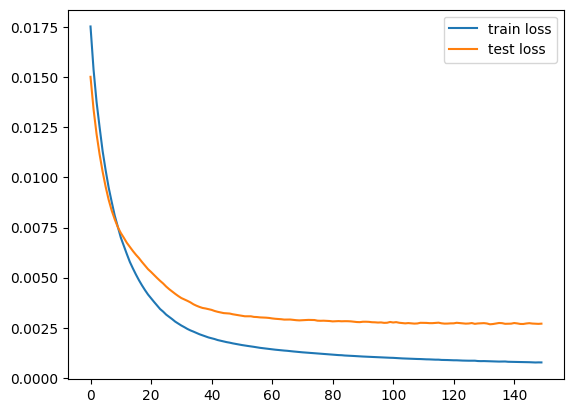

In [10]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

In [12]:
train_idx[:T+1] = False
Ptrain = model.predict(Xtrain).flatten()
Ptest = model.predict(Xtest).flatten()
df.loc[train_idx, 'Diff ANN Train Prediction'] = Ptrain
df.loc[test_idx, 'Diff ANN Test Prediction'] = Ptest

1/1 [==============================] - 0s 31ms/step


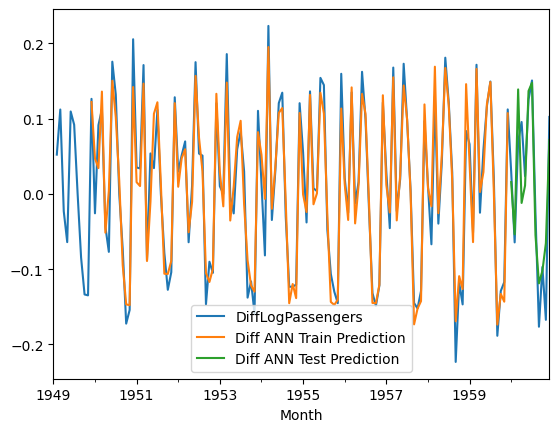

In [13]:
cols = ['DiffLogPassengers',
        'Diff ANN Train Prediction',
        'Diff ANN Test Prediction']
df[cols].plot();

In [14]:
df['ShiftedLogPassengers'] = df['LogPassengers'].shift(1)
prev = df['ShiftedLogPassengers']

In [15]:
last_train = train.iloc[-1]['LogPassengers']

In [16]:
# 1-step forecast
df.loc[train_idx, '1step_train'] = prev[train_idx] + Ptrain
df.loc[test_idx, '1step_test'] = prev[test_idx] + Ptest

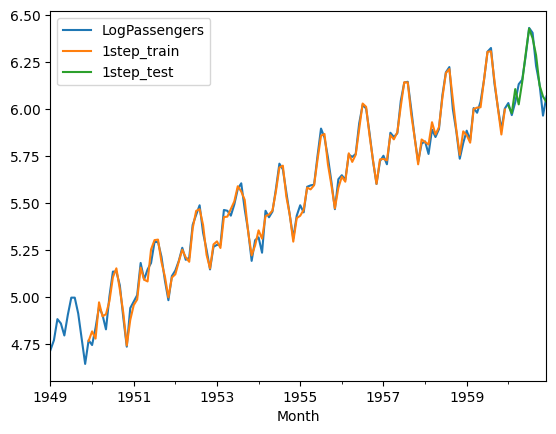

In [17]:
df[['LogPassengers', '1step_train', '1step_test']].plot();

In [18]:
# multistep
multistep_predictions = []

# first test input
last_x = Xtest[0]

while len(multistep_predictions) < Ntest:
    p = model.predict(last_x.reshape(1, -1))[0]

    # update the predictions list
    multistep_predictions.append(p)

    # make the new input
    last_x = np.roll(last_x, -1)
    last_x[-1] = p

1/1 [==============================] - 0s 42ms/step


C:\Users\zheng\AppData\Local\Temp\ipykernel_25412\1632378988.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_x[-1] = p


1/1 [==============================] - 0s 32ms/step


In [19]:
df.loc[test_idx, 'multistep'] = last_train + np.cumsum(multistep_predictions)

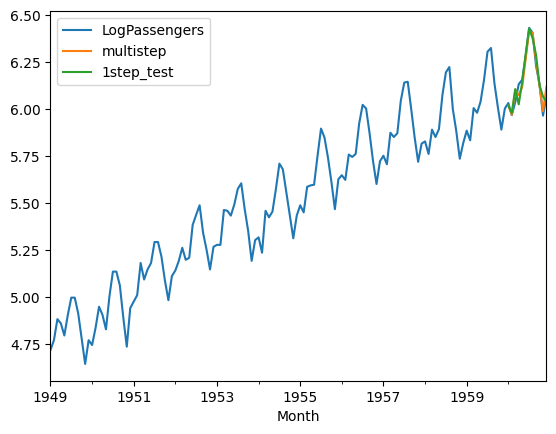

In [21]:
# plot 1-step and multi-step forecast
df[['LogPassengers', 'multistep', '1step_test']].plot();

In [22]:
# make multi-output supervised dataset
Tx = T
Ty = Ntest
X = []
Y = []
for t in range(len(series) - Tx - Ty + 1):
    x = series[t:t+Tx]
    X.append(x)
    y = series[t+Tx:t+Tx+Ty]
    Y.append(y)

X = np.array(X).reshape(-1, Tx)
Y = np.array(Y).reshape(-1, Ty)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (122, 10) Y.shape (122, 12)


In [23]:
Xtrain_m, Ytrain_m = X[:-1], Y[:-1]
Xtest_m, Ytest_m = X[-1:], Y[-1:]

In [27]:
# Model for multi-output
i = Input(shape=(Tx,))
x = Dense(32, activation='relu')(i)
x = Dense(Ty)(x)
model = Model(i, x)

model.compile(
    loss='mse',
    optimizer='adam'
)

In [28]:
r = model.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=150,
    validation_data=(Xtest_m, Ytest_m)
)

Epoch 1/150


4/4 [==============================] - 1s 64ms/step - loss: 0.0156 - val_loss: 0.0105
Epoch 2/150
4/4 [==============================] - 0s 17ms/step - loss: 0.0145 - val_loss: 0.0096
Epoch 3/150
4/4 [==============================] - 0s 16ms/step - loss: 0.0136 - val_loss: 0.0089
Epoch 4/150
4/4 [==============================] - 0s 15ms/step - loss: 0.0129 - val_loss: 0.0082
Epoch 5/150
4/4 [==============================] - 0s 15ms/step - loss: 0.0122 - val_loss: 0.0076
Epoch 6/150
4/4 [==============================] - 0s 16ms/step - loss: 0.0116 - val_loss: 0.0070
Epoch 7/150
4/4 [==============================] - 0s 15ms/step - loss: 0.0110 - val_loss: 0.0065
Epoch 8/150
4/4 [==============================] - 0s 16ms/step - loss: 0.0105 - val_loss: 0.0060
Epoch 9/150
4/4 [==============================] - 0s 15ms/step - loss: 0.0101 - val_loss: 0.0056
Epoch 10/150
4/4 [==============================] - 0s 15ms/step - loss: 0.0097 - val_loss: 0.0052
Epoch 11/150
4/4 [=============

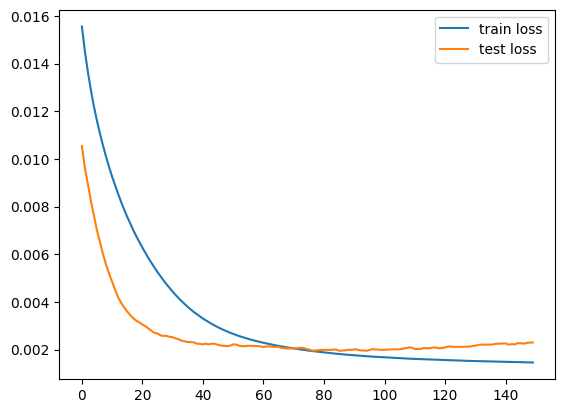

In [29]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

In [30]:
Ptrain = model.predict(Xtrain_m)
Ptest = model.predict(Xtest_m)

1/1 [==============================] - 0s 52ms/step


In [31]:
Ptrain = Ptrain[:,0]
Ptest = Ptest[0]

In [32]:
df.loc[test_idx, 'multioutput'] = last_train + np.cumsum(Ptest)

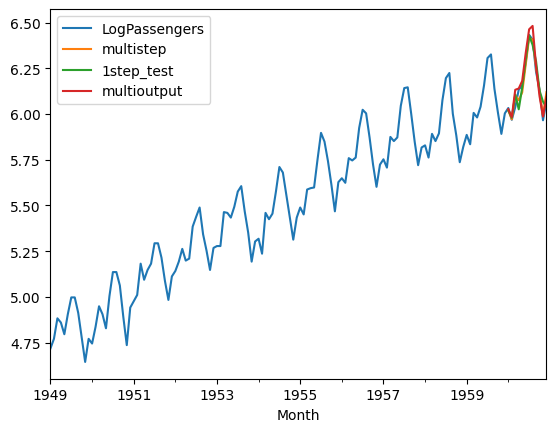

In [33]:
# plot all forecasts
cols = ['LogPassengers', 'multistep', '1step_test', 'multioutput']
df[cols].plot();

In [34]:
# MAPE
test_log_pass = df.iloc[-Ntest:]['LogPassengers']
mape1 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multistep'])
print("multi-step MAPE:", mape1)
mape2 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput'])
print("multi-output MAPE:", mape2)

multi-step MAPE: 0.004390365592975505
multi-output MAPE: 0.005590929731080506
